<a href="https://colab.research.google.com/github/URK21CO3006/coderscave-CVIP-DataScience/blob/%23CVIP%2FDataScience/Speech_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Speech Emotion recognition

Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import  to_categorical
from keras.callbacks import ModelCheckpoint
import warnings
import IPython.display as ipd
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Ravdess="/content/drive/MyDrive/audio_speech_actors_01-24"


Accessing and Reading the Audio File

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + "/" + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

In [ ]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)


Creating a dataframe for analysis


In [ ]:
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/audio_speech_actors_01-...
1,neutral,/content/drive/MyDrive/audio_speech_actors_01-...
2,neutral,/content/drive/MyDrive/audio_speech_actors_01-...
3,neutral,/content/drive/MyDrive/audio_speech_actors_01-...
4,calm,/content/drive/MyDrive/audio_speech_actors_01-...


In [ ]:
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/audio_speech_actors_01-...
1,neutral,/content/drive/MyDrive/audio_speech_actors_01-...
2,neutral,/content/drive/MyDrive/audio_speech_actors_01-...
3,neutral,/content/drive/MyDrive/audio_speech_actors_01-...
4,calm,/content/drive/MyDrive/audio_speech_actors_01-...


Visualization of Emotions/Different types of Emotions

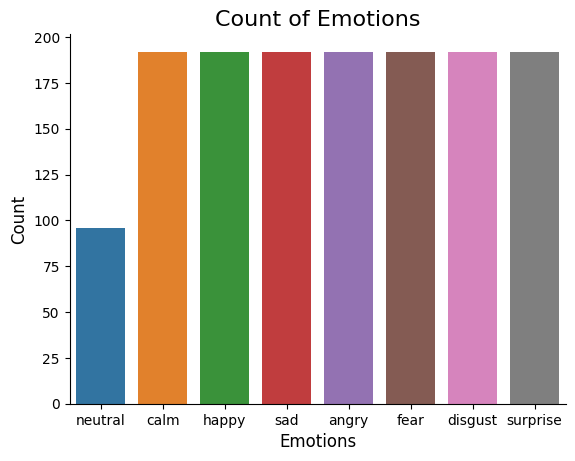

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path,x='Emotions')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Creation of spectrogram/waveplot

In [ ]:
def create_waveplot(data,sr,e):
  plt.figure(figsize=(10,3))
  plt.title("Waveplot for the Emotions".format(e),size=15)
  librosa.display.waveshow(data,sr=sr)
  plt.show()

def create_spectrogram(data,sr,e):
  X=librosa.stft(data)
  Xdb=librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12,3))
  plt.title('Spectrogram for the Emotions'.format(e),size=15)
  librosa.display.specshow(Xdb,sr=sr,x_axis='time',y_axis='hz')
  plt.colorbar()


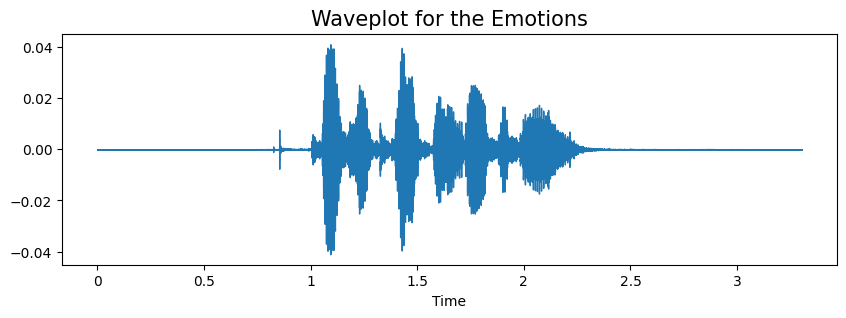

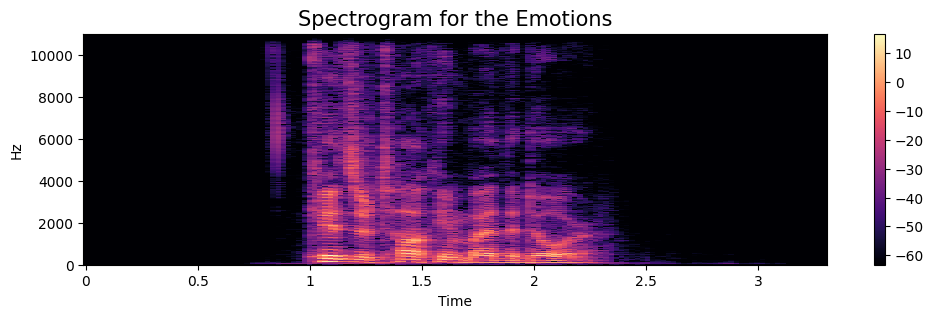

In [ ]:
path1="/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav"
emotion='neutral'
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path1)

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)


ipd.Audio(data, rate=sampling_rate)


Data Augmentation

In [ ]:

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y = data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path1='/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav'
data, sample_rate = librosa.load(path1)

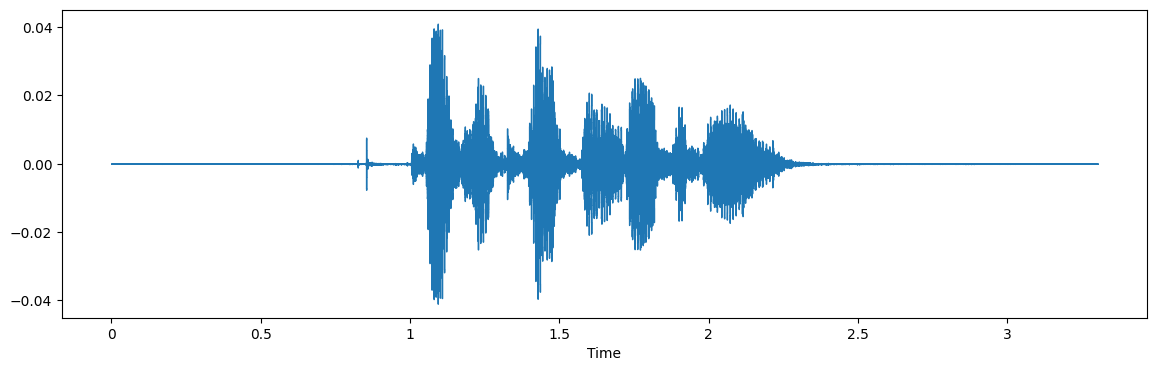

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path1)

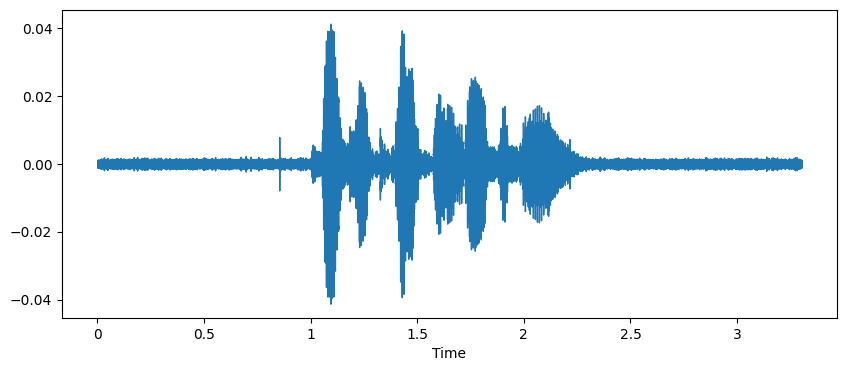

In [ ]:
x = noise(data)
plt.figure(figsize=(10,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

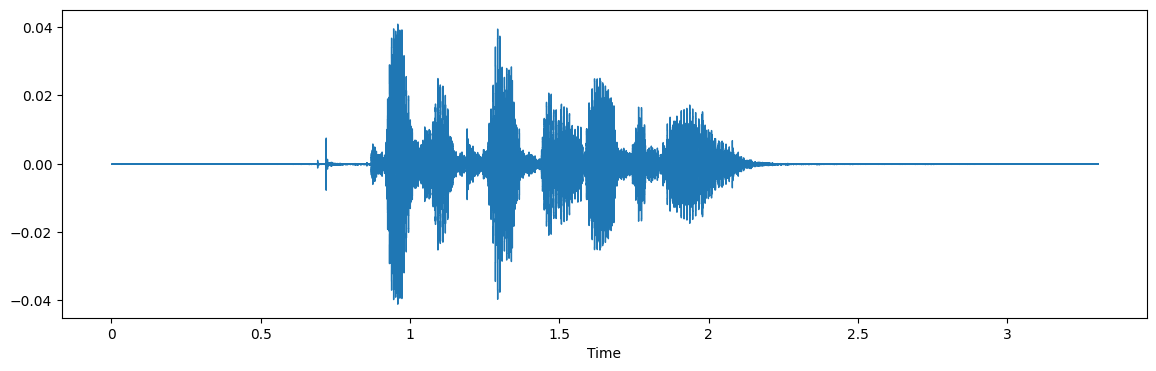

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

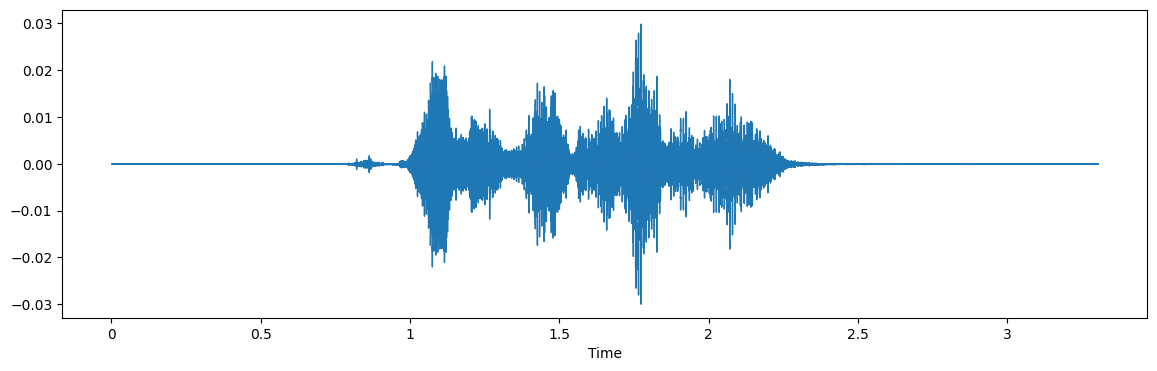

In [ ]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    shifted_data = librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)
    return shifted_data

x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
def extract_features(data):
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
  data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
  res1 = extract_features(data)
  result = np.array(res1)

  noise_data = noise(data)
  res2 = extract_features(noise_data)
  result = np.vstack((result, res2)) # stacking vertically


  new_data = stretch(data)
  data_stretch_pitch = pitch(new_data, sample_rate)
  res3 = extract_features(data_stretch_pitch)

  result = np.vstack((result, res3)) # stacking vertically

  return result

Feature Extraction

In [ ]:
X= []
Y=[]
path1 = "/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav"
feature = get_features(path = path1)
for ele in feature:
  X.append(ele)
  Y.append(emotion)

print(X)
print(Y)

[array([ 3.21275499e-01,  7.29663849e-01,  7.50032485e-01,  7.30624378e-01,
        7.35274613e-01,  7.13528514e-01,  6.60530746e-01,  6.84966326e-01,
        7.33049035e-01,  7.53971517e-01,  7.36093044e-01,  7.17019498e-01,
        6.68644786e-01, -6.45880737e+02,  7.26196365e+01,  8.41304660e-01,
        1.63994465e+01,  1.02415915e+01,  6.53902471e-01, -4.32800198e+00,
       -4.25893164e+00, -1.45758219e+01, -3.80628490e+00,  1.02242064e+00,
       -4.04266262e+00,  2.51959944e+00, -4.97224474e+00,  5.66446781e-01,
        1.03552616e+00, -5.41645098e+00, -2.44946885e+00, -1.78230608e+00,
       -1.21280527e+00,  2.98800319e-03,  1.78452149e-06,  7.42685370e-05,
        4.79519740e-03,  2.77164225e-02,  4.15456109e-02,  2.34019086e-02,
        4.56925808e-03,  2.46224571e-02,  3.26471515e-02,  2.70726420e-02,
        2.90551018e-02,  1.42193148e-02,  1.05155846e-02,  9.66812018e-03,
        1.99809745e-02,  4.81821336e-02,  6.59601539e-02,  1.71229728e-02,
        1.26172723e-02, 

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750032,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,4.310902e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116492e-06,8.190280e-06,0.000007,0.000005,4.245835e-07,neutral
1,0.272723,0.759884,0.765820,0.758742,0.774804,0.756449,0.671579,0.687620,0.719531,0.748734,...,5.221524e-06,4.066311e-06,2.817989e-06,3.013383e-06,5.686494e-06,8.738176e-06,0.000008,0.000006,1.135166e-06,neutral
2,0.188198,0.622088,0.699109,0.753246,0.721174,0.701756,0.682371,0.662858,0.686523,0.734027,...,8.577024e-07,9.576477e-07,7.733600e-07,5.233055e-07,3.593574e-07,9.267885e-07,0.000002,0.000001,7.754770e-08,neutral


Data Preparation

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2, 162), (2, 1), (1, 162), (1, 1))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2, 162), (2, 1), (1, 162), (1, 1))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2, 162, 1), (2, 1), (1, 162, 1), (1, 1))

Modelling

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0